# **Introducción a la Reducción Dimensional**
### **¿Por qué necesitamos reducir dimensiones?**
En el análisis de datos modernos, frecuentemente nos encontramos con conjuntos de datos que tienen muchas variables (dimensiones). Por ejemplo.
- Una imagen de 28x28 píxeles tiene 784 dimensiones
- Un documento de texto puede tener miles de palabras únicas (dimensiones)
- Datos genómicos pueden tener millones de características

### **La Maldición de la Dimensionalidad**

Se refiere a varios fenómenos que ocurren cuando analizamos datos en espacios de alta dimensión:
- Esparcimiento de datos: El volumen del espacio crece exponencialmente con cada dimensión
- Distancia entre puntos: En altas dimensiones, todos los puntos tienden a estar igualmente distantes
- Necesidad de datos: El número de muestras necesarias crece exponencialmente

In [1]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

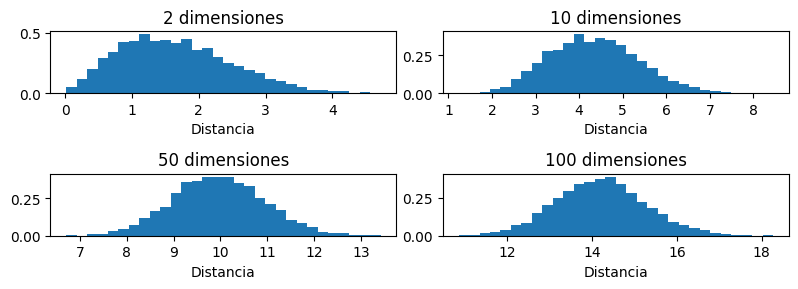

In [ ]:
# Crear datos sintéticos en diferentes dimensiones
np.random.seed(42)

def calculate_pairwise_distances(n_dimensions):
    # Generar 100 puntos en n_dimensions
    X = np.random.normal(0, 1, (100, n_dimensions))

    # Calcular distancias entre todos los pares de puntos
    distances = []
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            dist = np.sqrt(np.sum((X[i] - X[j])**2))
            distances.append(dist)
    return distances

dimensions = [2, 10, 50, 100]
plt.figure(figsize=(8, 3))

for i, dim in enumerate(dimensions):
    distances = calculate_pairwise_distances(dim)
    plt.subplot(2, 2, i+1)
    plt.hist(distances, bins=30, density=True)
    plt.title(f'{dim} dimensiones')
    plt.xlabel('Distancia')

plt.tight_layout()
plt.show()

Como podemos observar en las gráficas anteriores, a medida que aumenta la dimensionalidad:

- La distribución de distancias se vuelve más gaussiana
- Las distancias se concentran más lejos del origen
- La variabilidad relativa de las distancias disminuye

## **1. Panorama General de Técnicas de Reducción Dimensional**
 Existen dos grandes categorías de técnicas.
- **Métodos Lineales**
 - PCA (Principal component analysis - Análisis de Componentes Principales)
 - Factor Analysis
 - Linear Discriminant Analysis (LDA)
- **Métodos No Lineales**
 - t-SNE (t-distributed Stochastic Neighbor Embedding)
 - UMAP (Uniform Manifold Approximation)
 - Autoencoder Neural Networks

Veamos un ejemplo de datos que requieren reducción dimensional.

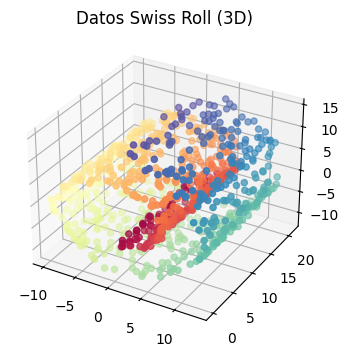

In [ ]:
from sklearn.datasets import make_swiss_roll

# Crear el conjunto de datos Swiss Roll
n_samples = 1000
X, color = make_swiss_roll(n_samples, noise=0.2, random_state=42)

# Visualizar en 3D
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title('Datos Swiss Roll (3D)')
plt.show()

## **2. Análisis de Componentes Principales (PCA)**
### **2.1 Fundamentos Matemáticos**
PCA es una técnica que busca encontrar las direcciones de máxima varianza en datos de alta dimensión. Matemáticamente, PCA encuentra los eigenvectores (vectores propios) de la matriz de covarianza de los datos.

**Proceso matemático del PCA**
- Centrado de datos:
 - Para cada característica $x_i$: $x_i' = x_i - \mu_i$
   
   donde $\mu_i$ es la media de la característica
- Cálculo de la matriz de covarianza:
 - $\Sigma = \frac{1}{n-1}X^TX$
  
   donde X es la matriz de datos centrada
- Descomposición en valores propios:
 - $\Sigma v = \lambda v$
   
   donde $\lambda$ son los valores propios y $v$ los vectores propios
 Veamos esto en la práctica:

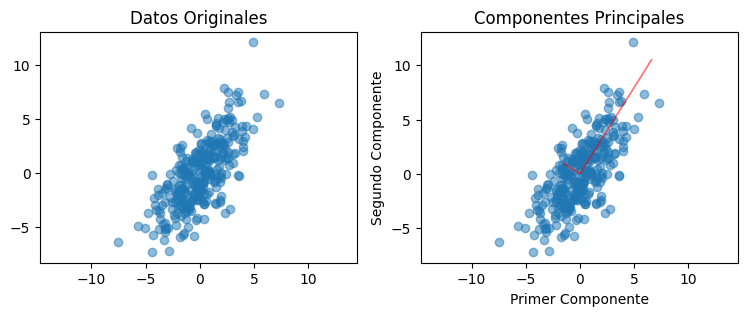

In [ ]:
# Crear datos de ejemplo
np.random.seed(42)
n_samples = 300
X = np.dot(np.random.normal(0, 1, (n_samples, 2)), [[2, 1], [1, 3]])

# Visualizar datos originales
plt.figure(figsize=(9, 3))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.title('Datos Originales')
plt.axis('equal')

# Calcular PCA manualmente
X_centered = X - X.mean(axis=0)
cov_matrix = np.cov(X_centered.T)
eigenvals, eigenvecs = np.linalg.eigh(cov_matrix)

# Ordenar eigenvalores y eigenvectores
idx = eigenvals.argsort()[::-1]
eigenvals = eigenvals[idx]
eigenvecs = eigenvecs[:, idx]

# Visualizar componentes principales
plt.subplot(122)
plt.scatter(X_centered[:, 0], X_centered[:, 1], alpha=0.5)
for i in range(2):
    plt.arrow(0, 0,
              eigenvecs[0, i] * eigenvals[i],
              eigenvecs[1, i] * eigenvals[i],
              color='r', alpha=0.5)
plt.title('Componentes Principales')
plt.axis('equal')
plt.xlabel('Primer Componente')
plt.ylabel('Segundo Componente')
plt.show()

### **2.2 Supuestos del PCA**
PCA tiene varios supuestos matemáticos importantes:
- Linealidad: las relaciones en los datos deben ser lineales
- Variables continuas: las variables deben ser continuas o al menos ordinales
- Correlación: debe existir algún grado de correlación entre las variables
- Outliers: PCA es sensible a valores atípicos

### **2.3 Preparación de Datos**
La preparación adecuada de los datos es crucial para PCA. Los pasos principales son:
- Estandarización: Crucial cuando las variables tienen diferentes escalas
- Manejo de valores faltantes (solo en caso de existir): Imputación o eliminación
- Tratamiento de outliers (solo en caso de existir): Eliminación o transformación

En el siguiente ejemplo se muestra un como un dataset con dos variables con diferentes escalas y valores es transformado para poder aplicar PCA.

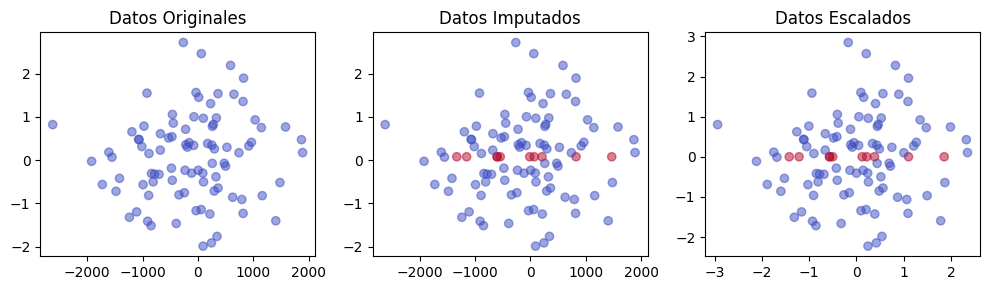

In [ ]:
# Crear datos con valores faltantes y diferentes escalas
np.random.seed(42)
X_messy = np.random.normal(0, 1, (100, 2))
X_messy[:, 0] = X_messy[:, 0] * 1000  # Diferente escala
X_messy[10:20, 1] = np.nan  # Valores faltantes

def prepare_data_for_pca(X):
    # Crear una máscara de los datos faltantes
    missing_mask = np.isnan(X)

    # Imputación de valores faltantes
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Estandarización
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))

    # Datos originales
    axes[0].scatter(X[:, 0], X[:, 1], c=missing_mask[:, 1], alpha=0.5, cmap='coolwarm')
    axes[0].set_title('Datos Originales')


    # Datos imputados
    axes[1].scatter(X_imputed[:, 0], X_imputed[:, 1], c=missing_mask[:, 1], alpha=0.5, cmap='coolwarm')
    axes[1].set_title('Datos Imputados')

    # Datos escalados
    axes[2].scatter(X_scaled[:, 0], X_scaled[:, 1], c=missing_mask[:, 1], alpha=0.5, cmap='coolwarm')
    axes[2].set_title('Datos Escalados')

    plt.tight_layout()
    plt.show()

    return X_scaled

X_prepared = prepare_data_for_pca(X_messy)

### **2.4 Implementación e Interpretación**
Ahora veremos cómo implementar PCA y evaluar sus resultados. En el ejemplo utilizaremos un dataset de ejemplo que contiene características físicas como ancho y largo de petalo y sepalo para 3 clases de especies de flor Iris. Reduciremos la dimension del dataset de 4 variables a 2 componentes principales, y mostraremos como esto facilita la visualización de los datos por especie.

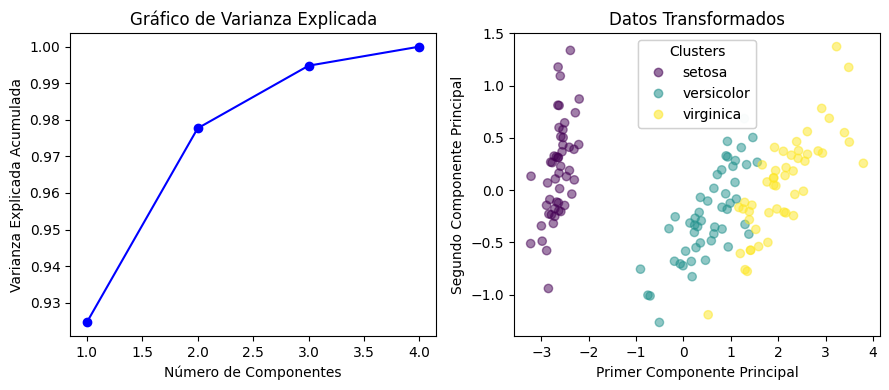

In [ ]:
# Cargar el conjunto de datos iris
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names

def implement_and_evaluate_pca(X, y, target_names, n_components=None):
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_transformed = pca.fit_transform(X)

    # Calcular varianza explicada
    explained_variance_ratio = pca.explained_variance_ratio_

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    # Scree plot
    n_components = len(explained_variance_ratio)
    axes[0].plot(range(1, n_components + 1),
                 np.cumsum(explained_variance_ratio), 'bo-')
    axes[0].set_xlabel('Número de Componentes')
    axes[0].set_ylabel('Varianza Explicada Acumulada')
    axes[0].set_title('Gráfico de Varianza Explicada')

    # Datos transformados
    if X_transformed.shape[1] >= 2:
        scatter = axes[1].scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, alpha=0.5, cmap='viridis')
        axes[1].set_xlabel('Primer Componente Principal')
        axes[1].set_ylabel('Segundo Componente Principal')
        axes[1].set_title('Datos Transformados')

        # Crear leyenda utilizando target_names
        handles, _ = scatter.legend_elements()
        legend_labels = [target_names[int(i)] for i in np.unique(y)]
        legend = axes[1].legend(handles, legend_labels, title="Clusters")
        axes[1].add_artist(legend)

    plt.tight_layout()
    plt.show()

    return pca, X_transformed

# Aplicar PCA a nuestros datos preparados
pca, X_pca = implement_and_evaluate_pca(X, y, target_names)


#### **Interpretación de Resultados**
En general se suele selecionar el número de componentes principales que expliquen al menos el 0.7 (70%) de varianza. Los resultados anteriores nos muestran:
- La varianza explicada por cada componente
- La transformación de los datos a un espacio de menor dimensión (2 dimensiones)
- La estructura de los datos en términos de sus componentes principales



#### **2.4.1 Loading Plot y Biplot**
Los loading plots son visualizaciones cruciales que muestran cómo las variables originales contribuyen a los componentes principales. Un Biplot es una combinación entre el gráfico de componentes principales por clase y un loading plot.

**¿Qué son los Loadings?**

Los loadings son los coeficientes que relacionan las variables originales con los componentes principales. Cada loading se respresenta por un vector.

- Magnitud del Loading
 - Loadings cercanos a ±1 indican fuerte influencia
 - Loadings cercanos a 0 indican poca influencia
 - El signo indica la dirección de la correlación

- Patrones en Loading Plot
 - Variables cercanas están correlacionadas positivamente
 - Variables opuestas están correlacionadas negativamente
 - Variables perpendiculares son independientes

Veremos ejemplos de como representar los loadings, loading plots y biplots para dos datasets de ejemplo.

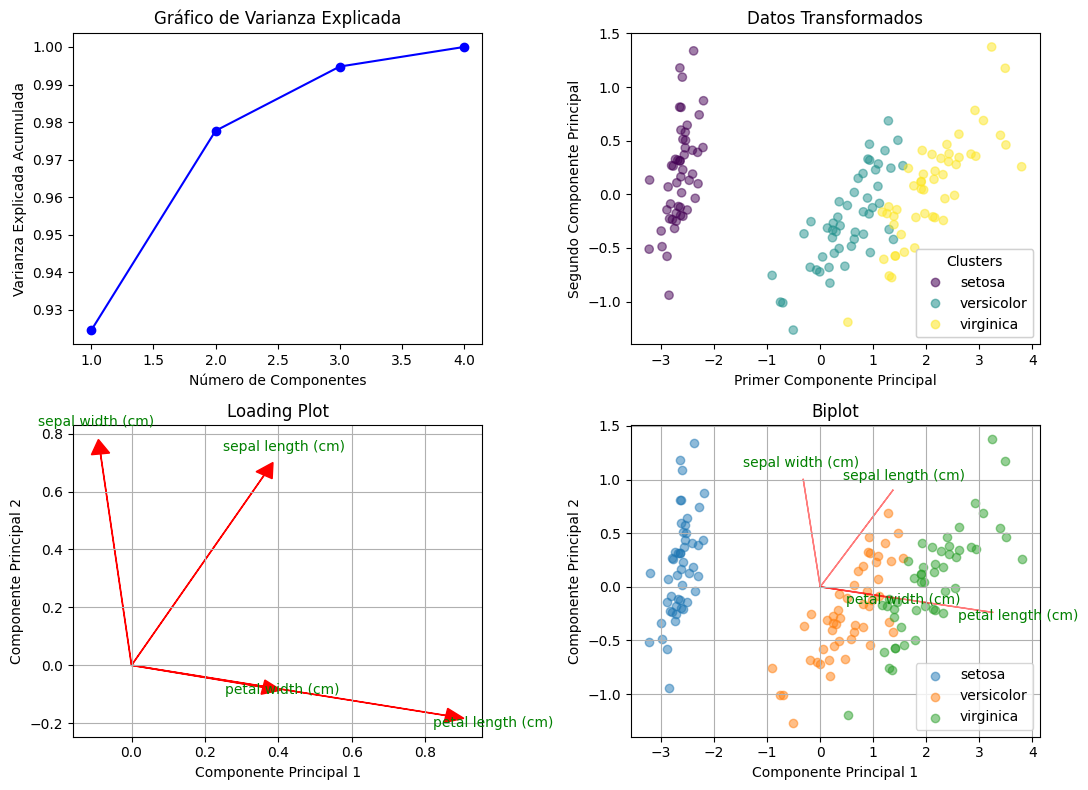

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA

# Cargar el conjunto de datos iris
iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = iris.target_names
feature_names = iris.feature_names

def implement_and_evaluate_pca(X, y, target_names, feature_names, n_components=None):
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_transformed = pca.fit_transform(X)

    # Calcular varianza explicada
    explained_variance_ratio = pca.explained_variance_ratio_

    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(11, 8))

    # Scree plot
    n_components = len(explained_variance_ratio)
    axes[0, 0].plot(range(1, n_components + 1),
                    np.cumsum(explained_variance_ratio), 'bo-')
    axes[0, 0].set_xlabel('Número de Componentes')
    axes[0, 0].set_ylabel('Varianza Explicada Acumulada')
    axes[0, 0].set_title('Gráfico de Varianza Explicada')

    # Datos transformados
    if X_transformed.shape[1] >= 2:
        scatter = axes[0, 1].scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, alpha=0.5, cmap='viridis')
        axes[0, 1].set_xlabel('Primer Componente Principal')
        axes[0, 1].set_ylabel('Segundo Componente Principal')
        axes[0, 1].set_title('Datos Transformados')

        # Crear leyenda utilizando target_names
        handles, _ = scatter.legend_elements()
        legend_labels = [target_names[int(i)] for i in np.unique(y)]
        legend = axes[0, 1].legend(handles, legend_labels, title="Clusters")
        axes[0, 1].add_artist(legend)

    # Loading plot
    for i in range(pca.components_.shape[1]):
        axes[1, 0].arrow(0, 0, pca.components_[0, i], pca.components_[1, i],
                         head_width=0.05, head_length=0.05, color='r')
        axes[1, 0].text(pca.components_[0, i] * 1.15, pca.components_[1, i] * 1.15,
                        feature_names[i], color='g', ha='center', va='center')
    axes[1, 0].set_xlabel('Componente Principal 1')
    axes[1, 0].set_ylabel('Componente Principal 2')
    axes[1, 0].set_title('Loading Plot')
    axes[1, 0].grid()

    # Biplot
    for i, target_name in zip(np.unique(y), target_names):
        axes[1, 1].scatter(X_transformed[y == i, 0], X_transformed[y == i, 1],
                           alpha=0.5, label=target_name)
    for i in range(pca.components_.shape[1]):
        axes[1, 1].arrow(0, 0, pca.components_[0, i] * max(X_transformed[:, 0]),
                         pca.components_[1, i] * max(X_transformed[:, 1]),
                         color='r', alpha=0.5)
        axes[1, 1].text(pca.components_[0, i] * max(X_transformed[:, 0]) * 1.15,
                        pca.components_[1, i] * max(X_transformed[:, 1]) * 1.15,
                        feature_names[i], color='g', ha='center', va='center')
    axes[1, 1].set_xlabel('Componente Principal 1')
    axes[1, 1].set_ylabel('Componente Principal 2')
    axes[1, 1].set_title('Biplot')
    axes[1, 1].legend()
    axes[1, 1].grid()

    plt.tight_layout()
    plt.show()

    return pca, X_transformed

# Aplicar PCA a nuestros datos preparados
pca, X_pca = implement_and_evaluate_pca(X, y, target_names, feature_names)

#### **Interpretación de Resultados**
- Petal width influencia de forma fuerte y positiva al componente principal 1
- Petal length influencia de forma fuerte y positiva al componente principal 1
- Sepal width influencia de forma fuerte y positiva al componente principal 2
- Sepal length influencia de forma fuerte y positiva al componente principal 2

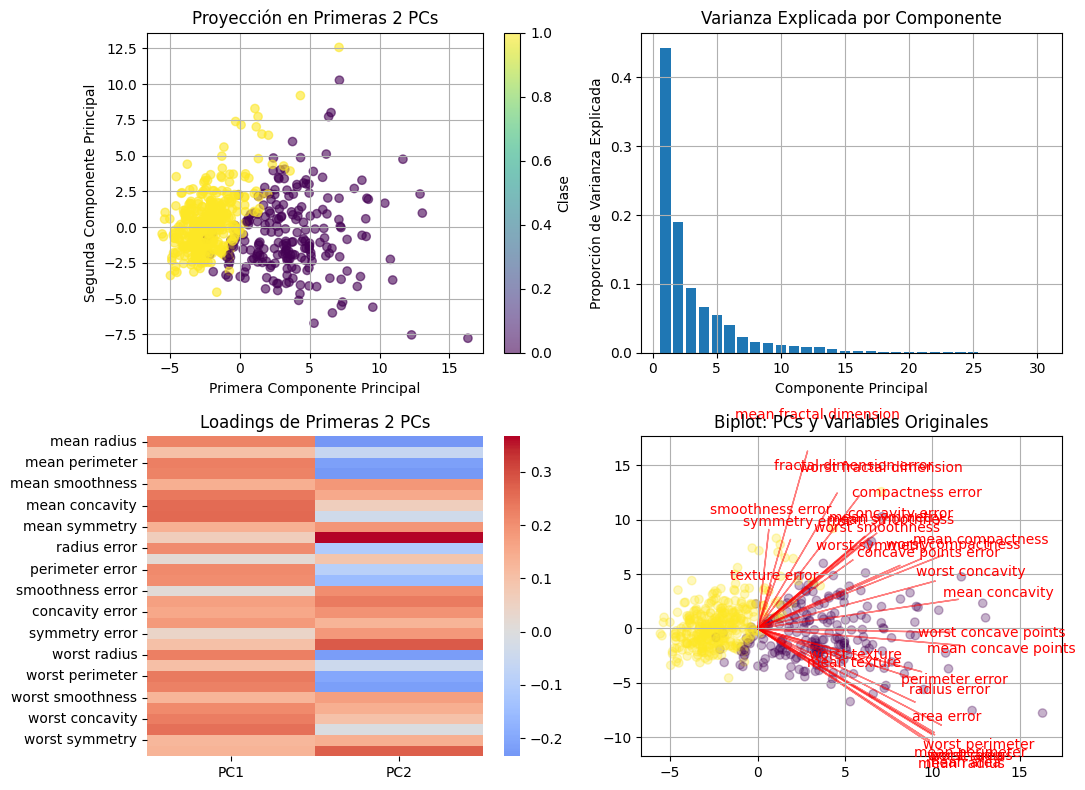

In [ ]:
# Cargar el conjunto de datos iris
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
target_names = cancer.target_names
feature_names = cancer.feature_names

def implement_and_evaluate_pca_2(X, y, target_names, feature_names):
    # Estandarizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Aplicar PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(11, 8))

    # Scatter plot de primeros dos componentes
    scatter = axes[0,0].scatter(X_pca[:, 0], X_pca[:, 1],
                               c=y, cmap='viridis', alpha=0.6)
    axes[0,0].set_xlabel('Primera Componente Principal')
    axes[0,0].set_ylabel('Segunda Componente Principal')
    axes[0,0].set_title('Proyección en Primeras 2 PCs')
    axes[0,0].grid(True)
    plt.colorbar(scatter, ax=axes[0,0], label='Clase')

    # Varianza explicada
    axes[0,1].bar(range(1, len(pca.explained_variance_ratio_) + 1),
                 pca.explained_variance_ratio_)
    axes[0,1].set_xlabel('Componente Principal')
    axes[0,1].set_ylabel('Proporción de Varianza Explicada')
    axes[0,1].set_title('Varianza Explicada por Componente')
    axes[0,1].grid(True)

    # Loadings (coeficientes) para primeras dos componentes
    loadings = pca.components_[:2].T
    loading_matrix = pd.DataFrame(
        loadings,
        columns=['PC1', 'PC2'],
        index=feature_names
    )
    sns.heatmap(loading_matrix, cmap='coolwarm', center=0, ax=axes[1,0])
    axes[1,0].set_title('Loadings de Primeras 2 PCs')

    # Biplot
    # Normalizar loadings para visualización
    n_features = len(feature_names)
    scaling = np.max(np.abs(X_pca[:, :2]))/np.max(np.abs(loadings))

    axes[1,1].scatter(X_pca[:, 0], X_pca[:, 1],
                     c=y, cmap='viridis', alpha=0.3)

    for i, (x, y) in enumerate(zip(loadings[:, 0], loadings[:, 1])):
        axes[1,1].arrow(0, 0, x*scaling, y*scaling, color='r', alpha=0.5)
        axes[1,1].text(x*scaling*1.2, y*scaling*1.2, feature_names[i],
                      color='r', ha='center', va='center')

    axes[1,1].set_title('Biplot: PCs y Variables Originales')
    axes[1,1].grid(True)

    plt.tight_layout()
    plt.show()

implement_and_evaluate_pca_2(X, y, target_names, feature_names)

#### **Interpretación de Resultados**
- El componente principal 1 está más influenciado por worst concave, mean concavity, mean concave points
- El componente principal 2 está más influenciado por worst fractal dimension, fractal dimension error, mean fractal dimension

## **3. t-SNE (t-Distributed Stochastic Neighbor Embedding)**
### **3.1 Fundamentos Conceptuales**
t-SNE es una técnica de reducción dimensional no lineal que se centra en preservar la estructura local de los datos. A diferencia de PCA, t-SNE es particularmente efectivo para visualizar clusters y estructuras no lineales.

**Fundamento Matemático**

t-SNE opera en dos pasos principales.
- Similitudes en el espacio de alta dimensión:
 - Para cada par de puntos $x_i$ y $x_j$, se calcula una probabilidad condicional $p_{j|i}$:

    $p_{j|i} = \frac{\exp(-||x_i - x_j||^2/2\sigma_i^2)}{\sum_{k \neq i}\exp(-||x_i - x_k||^2/2\sigma_i^2)}$

- Similitudes en el espacio de baja dimensión:
 - Para los puntos proyectados $y_i$ y $y_j$, se usa una distribución t de Student:

    $q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l}(1 + ||y_k - y_l||^2)^{-1}}$

 - El objetivo es minimizar la divergencia de Kullback-Leibler entre ambas distribuciones:

    $C = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}$


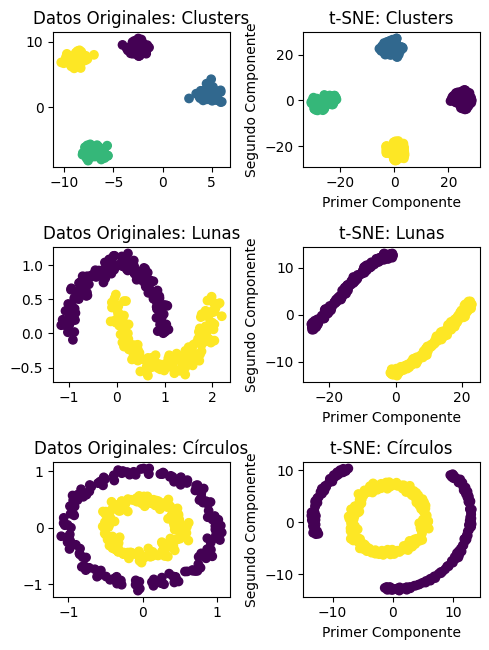

In [3]:
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs, make_moons, make_circles

# Crear diferentes conjuntos de datos sintéticos
def create_example_datasets():
    # Blobs
    X_blobs, y_blobs = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=42)

    # Lunas
    X_moons, y_moons = make_moons(n_samples=300, noise=0.075, random_state=42)

    # Círculos concéntricos
    X_circles, y_circles = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)

    return [(X_blobs, y_blobs, "Clusters"),
            (X_moons, y_moons, "Lunas"),
            (X_circles, y_circles, "Círculos")]

# Visualizar datos originales y su transformación t-SNE
def visualize_tsne_comparison(datasets):
    fig, axes = plt.subplots(len(datasets), 2, figsize=(5, 2.2*len(datasets)))

    for idx, (X, y, title) in enumerate(datasets):
        # Datos originales
        axes[idx, 0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
        axes[idx, 0].set_title(f'Datos Originales: {title}')

        # Aplicar t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        X_tsne = tsne.fit_transform(X)

        # Visualizar t-SNE
        axes[idx, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
        axes[idx, 1].set_title(f't-SNE: {title}')
        axes[idx, 1].set_xlabel('Primer Componente')
        axes[idx, 1].set_ylabel('Segundo Componente')

    plt.tight_layout()
    plt.show()

# Ejecutar visualización
datasets = create_example_datasets()
visualize_tsne_comparison(datasets)

### **3.2 Parámetros Clave de t-SNE**
**Perplejidad**

La perplejidad el parámetro más importantes en t-SNE. Se puede interpretar como una estimación del número de vecinos cercanos que cada punto debería considerar.

Matemáticamente:

- $Perp(P_i) = 2^{H(P_i)}$

 donde $H(P_i)$ es la entropía de la distribución de probabilidad condicional
 $H(P_i) = -\sum_j p_{j|i} \log_2 p_{j|i}$

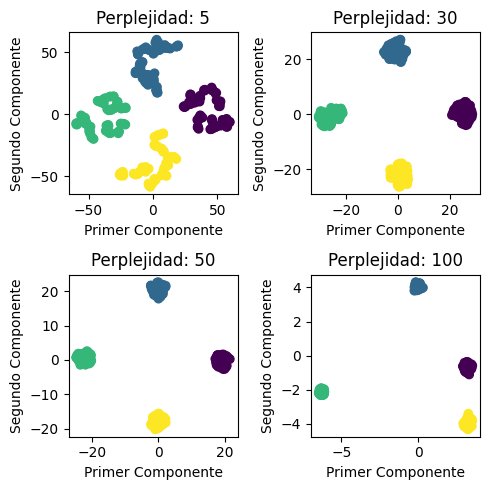

In [ ]:
# Comparar valores de perplejidad
def compare_perplexities(X, y, perplexities=[5, 30, 50, 100]):
    fig, axes = plt.subplots(2, 2, figsize=(5, 5))
    axes = axes.ravel()

    for idx, perp in enumerate(perplexities):
        tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
        X_tsne = tsne.fit_transform(X)

        axes[idx].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
        axes[idx].set_title(f'Perplejidad: {perp}')
        axes[idx].set_xlabel('Primer Componente')
        axes[idx].set_ylabel('Segundo Componente')

    plt.tight_layout()
    plt.show()

# Usar el conjunto de datos de clusters
X, y, _ = datasets[0]
compare_perplexities(X, y)

### **3.3 Consideraciones Prácticas**
**Escalabilidad y Tiempo de Ejecución**

t-SNE tiene una complejidad computacional de O(n²). Esto indica que el tiempo de cálculo aumenta de forma cuadrática conforme aumentamos el número de registros (filas) en el dataset. Esto puede ser problemático para conjuntos de datos grandes. Veamos cómo el tiempo de ejecución escala con el tamaño de los datos.

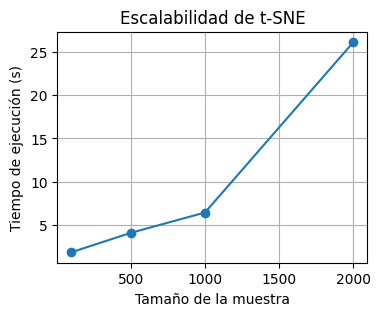

In [ ]:
# Comparar tiempo de ejecución
import time

def analyze_tsne_scaling():
    sample_sizes = [100, 500, 1000, 2000]
    times = []

    for n in sample_sizes:
        X, y = make_blobs(n_samples=n, centers=4, random_state=42)

        t0 = time.time()
        tsne = TSNE(n_components=2)
        tsne.fit_transform(X)
        t1 = time.time()

        times.append(t1 - t0)

    plt.figure(figsize=(4, 3))
    plt.plot(sample_sizes, times, 'o-')
    plt.xlabel('Tamaño de la muestra')
    plt.ylabel('Tiempo de ejecución (s)')
    plt.title('Escalabilidad de t-SNE')
    plt.grid(True)
    plt.show()

analyze_tsne_scaling()

## **4. Comparación y Selección de Técnicas**
### **4.1 PCA vs. t-SNE**
Vamos a comparar PCA y t-SNE en diferentes tipos de datos para entender sus fortalezas y debilidades.

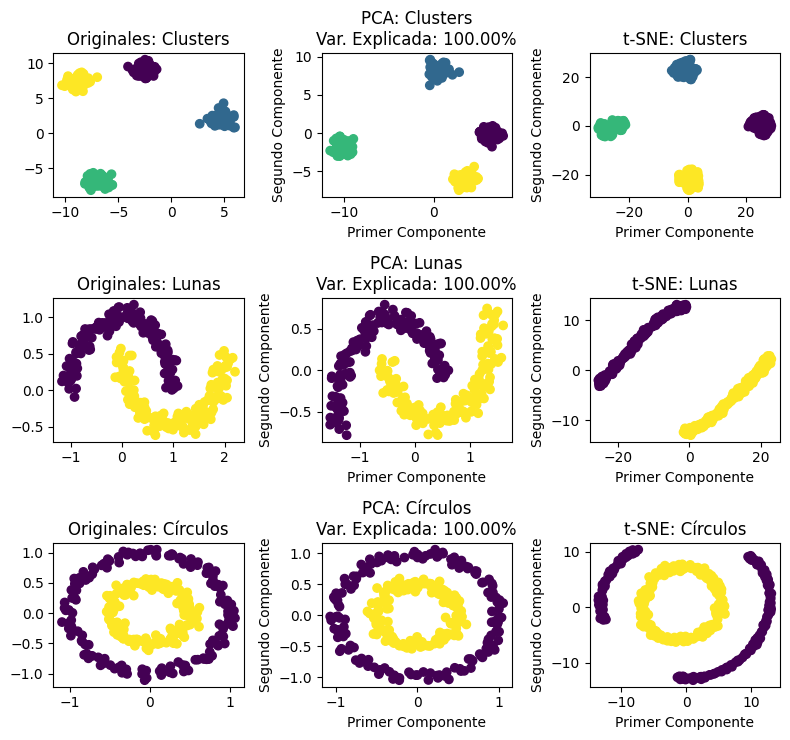

In [4]:
# Comparar PCA y t-SNE
from sklearn.decomposition import PCA

def compare_pca_tsne(datasets):
    fig, axes = plt.subplots(len(datasets), 3, figsize=(8, 2.5*len(datasets)))

    for idx, (X, y, title) in enumerate(datasets):
        # Datos originales
        axes[idx, 0].scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
        axes[idx, 0].set_title(f'Originales: {title}')

        # PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        var_ratio = pca.explained_variance_ratio_
        axes[idx, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
        axes[idx, 1].set_title(f'PCA: {title}\nVar. Explicada: {sum(var_ratio):.2%}')
        axes[idx, 1].set_xlabel('Primer Componente')
        axes[idx, 1].set_ylabel('Segundo Componente')

        # t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(X)
        axes[idx, 2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
        axes[idx, 2].set_title(f't-SNE: {title}')
        axes[idx, 2].set_xlabel('Primer Componente')
        axes[idx, 2].set_ylabel('Segundo Componente')

    plt.tight_layout()
    plt.show()

compare_pca_tsne(datasets)

#### **4.1.1 Clusters**

- **Datos Originales:**
 - Los datos muestran 4 grupos claramente separados
 - Estructura lineal con clusters bien definidos
 - Dispersión uniforme dentro de cada cluster

- **Resultados PCA:**
 - Conserva casi perfectamente la estructura original (98% varianza explicada)
 - Mantiene las distancias relativas entre clusters
 - Preserva la forma circular de los clusters
 - La separación entre grupos es clara y proporcional a la original

- **Resultados t-SNE:**
  - Separa los clusters de manera más pronunciada
  - Aumenta el espacio entre grupos
  - Mantiene la cohesión interna de cada cluster
  - Puede distorsionar ligeramente la forma circular original

#### **4.1.2 Lunas**

- **Datos Originales:**
  - Dos estructuras curvilíneas entrelazadas
  - Patrón no lineal claro
  - Separación uniforme entre las dos clases

- **Resultados PCA:**
  - Menor rendimiento (72% varianza explicada)
  - No logra separar completamente las clases
  - Las lunas aparecen superpuestas
  - Pierde la estructura no lineal característica

- **Resultados t-SNE:**
  - Separa perfectamente las dos clases
  - Preserva la estructura curvilínea
  - Mantiene la continuidad dentro de cada luna
  - Enfatiza la separación natural entre las clases

#### **4.1.3 Círculos**

- **Datos Originales:**
  - Dos círculos concéntricos
  - Estructura no lineal clara
  - Distancia uniforme entre círculos

- **Resultados PCA:**
  - Rendimiento pobre (51% varianza explicada)
  - No puede separar los círculos
  - Pierde completamente la estructura concéntrica
  - Los datos aparecen mezclados

- **Resultados t-SNE:**
  - Separa perfectamente los círculos
  - Transforma la estructura concéntrica en dos grupos distintos
  - Preserva la continuidad de cada círculo
  - Mantiene la densidad uniforme dentro de cada clase

#### **4.1.4 Análisis Comparativo General**

**Fortalezas de PCA**

- **Preservación de Estructura Lineal:**
 - Excelente en el caso de los clusters
 - Mantiene proporciones de distancias globales
 - Varianza explicada cuantificable

- **Consistencia:**
 - Resultados reproducibles
 - Transformación determinística
 - Interpretabilidad de componentes

- **Eficiencia:**
 - Rápido computacionalmente
 - Escalable a grandes conjuntos de datos
 - No requiere ajuste de hiperparámetros

**Debilidades de PCA**

- **Limitaciones con no Linealidad:**
   - Pobre rendimiento en lunas y círculos
   - No puede capturar relaciones curvilíneas
   - Pérdida significativa de información en estructuras complejas

- **Rigidez de Transformación:**
   - Transformación lineal únicamente
   - No puede adaptar la proyección localmente
   - Dependiente de la orientación global de los datos

**Fortalezas de t-SNE**

- **Captura de Estructura No Lineal:**
   - Excelente en todos los casos de prueba
   - Preserva relaciones locales complejas
   - Adapta la proyección según la estructura local

- **Separación de Clusters:**
   - Clara diferenciación entre grupos
   - Preservación de densidades locales
   - Mantiene continuidad dentro de cada clase

- **Flexibilidad:**
   - Adaptación a diferentes tipos de estructuras
   - Preservación de patrones locales
   - Enfatiza características importantes de los datos

**Debilidades de t-SNE**

- **Variabilidad:**
   - Resultados no determinísticos
   - Depende de la inicialización
   - Puede variar entre ejecuciones

- **Interpretabilidad:**
   - Distancias globales no significativas
   - No hay medida explícita de varianza explicada
   - Ejes no tienen interpretación directa

### **4.2 Criterios de Selección**
 Para elegir entre PCA y t-SNE, consideremos varios factores.
- **Objetivo del análisis**
 - Visualización → t-SNE
 - Reducción dimensional para machine learning → PCA
 - Interpretación de variables → PCA
- **Características de los datos**
 - Relaciones lineales → PCA
 - Clusters no lineales → t-SNE
 - Alta dimensionalidad → PCA seguido de t-SNE

 ## **5. Comparación de PCA vs t-SNE**

 En esta lectura, analizaremos tres datasets reales para comparar el rendimiento y aplicabilidad de PCA y t-SNE.
- Dataset de dígitos manuscritos (reconocimiento de imágenes)
- Dataset de expresión genética de cáncer de mama
- Dataset de características de vinos

In [12]:
from sklearn.datasets import load_digits, load_breast_cancer, load_wine

# Funcion para comparar PCA vs. t-SNE
def compare_pca_tsne(X, y, target_names):
    # Escalar datos
    X_scaled = StandardScaler().fit_transform(X)

    # Aplicar PCA primero
    pca = PCA(n_components=0.95, svd_solver='full')  # Mantener 95% de la varianza
    X_pca = pca.fit_transform(X_scaled)
    var_ratio = pca.explained_variance_ratio_

    # Aplicar t-SNE a los resultados de PCA
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_pca)

    # Visualización
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # PCA completo
    pca_full = PCA(n_components=2)
    X_pca_full = pca_full.fit_transform(X_scaled)
    scatter = axes[0].scatter(X_pca_full[:, 0], X_pca_full[:, 1], c=y, cmap='viridis')
    axes[0].set_title(f'PCA (2 comp.)\nVarianza Explicada: {sum(var_ratio):.2%}')
    axes[0].set_xlabel('Primer Componente')
    axes[0].set_ylabel('Segundo Componente')
    # Crear leyenda utilizando target_names
    handles, _ = scatter.legend_elements()
    legend_labels = [target_names[int(i)] for i in np.unique(y)]
    legend = axes[0].legend(handles, legend_labels)
    axes[0].add_artist(legend)

    # t-SNE directo
    tsne_direct = TSNE(n_components=2, random_state=42)
    X_tsne_direct = tsne_direct.fit_transform(X_scaled)
    scatter = axes[1].scatter(X_tsne_direct[:, 0], X_tsne_direct[:, 1], c=y, cmap='viridis')
    axes[1].set_title('t-SNE')
    axes[1].set_xlabel('Primer Componente')
    axes[1].set_ylabel('Segundo Componente')
    # Crear leyenda utilizando target_names
    handles, _ = scatter.legend_elements()
    legend_labels = [target_names[int(i)] for i in np.unique(y)]
    legend = axes[1].legend(handles, legend_labels)
    axes[1].add_artist(legend)

    # PCA + t-SNE
    scatter = axes[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
    axes[2].set_title(f'PCA ({X_pca.shape[1]} comp.) + t-SNE')
    axes[2].set_xlabel('Primer Componente')
    axes[2].set_ylabel('Segundo Componente')
    # Crear leyenda utilizando target_names
    handles, _ = scatter.legend_elements()
    legend_labels = [target_names[int(i)] for i in np.unique(y)]
    legend = axes[2].legend(handles, legend_labels)
    axes[2].add_artist(legend)

    plt.tight_layout()
    plt.show()

    # Dimensiones y numero de clases
    print("Dimensione inicial (variables):", X.shape[1])
    print("Número de clases:", len(np.unique(y)))
    print(f"Número de componentes PCA para 95% de varianza: {pca.n_components_}")

### **5.1 Dígitos Manuscritos**
 El dataset de dígitos manuscritos contiene 8x8 imágenes en escala de grises de dígitos escritos a mano (0-9).
 Cada imagen está representada como un vector de 64 características (los valores de píxeles).

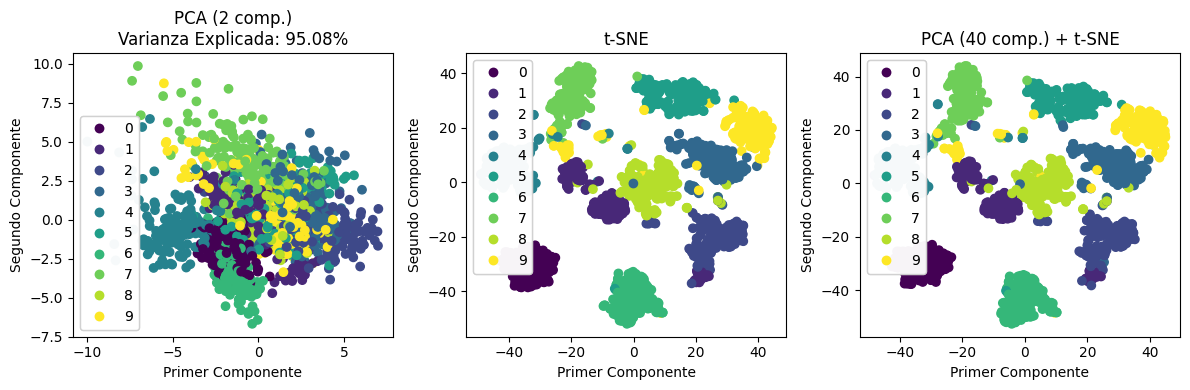

Dimensione inicial (variables): 64
Número de clases: 10
Número de componentes PCA para 95% de varianza: 40


In [13]:
# Cargar datos de dígitos y analizar
digits = load_digits()
X_digits, y_digits, target_names = digits.data, digits.target, digits.target_names
n_components = compare_pca_tsne(X_digits, y_digits, target_names)

**Análisis de Resultados**

 - **PCA:**
  - Logra explicar aproximadamente el 45% de la varianza con 2 componentes
  - Los dígitos muestran cierto grado de superposición
  - Se pueden observar algunas agrupaciones, pero no son completamente claras
  - Mantiene la estructura global pero pierde detalles locales

 - **t-SNE:**
  - Separa los dígitos en clusters bien definidos
  - Cada dígito forma un grupo distintivo
  - Preserva mejor la estructura local y similitudes entre dígitos similares
  - Mayor claridad en la visualización de los diferentes grupos

### **5.2  Cáncer de Mama**
 Este dataset contiene características extraídas de imágenes digitales de biopsias de mama.
 Incluye mediciones de células y se usa para clasificar tumores como malignos o benignos.

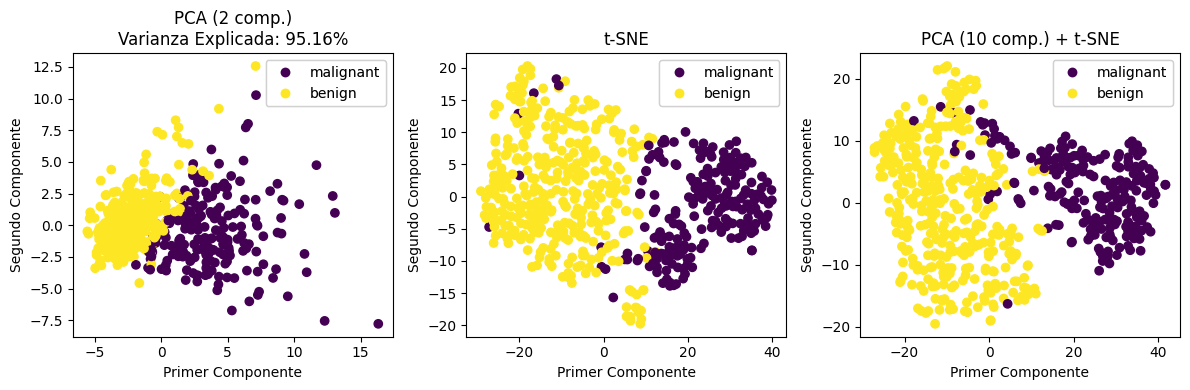

Dimensione inicial (variables): 30
Número de clases: 2
Número de componentes PCA para 95% de varianza: 10


In [14]:
# Cargar datos cancer y analizar
cancer = load_breast_cancer()
X_cancer, y_cancer, target_names = cancer.data, cancer.target, cancer.target_names
n_components = compare_pca_tsne(X_cancer, y_cancer, target_names)

**Análisis de Resultados**

 - **PCA:**
  - Explica aproximadamente el 63% de la varianza con 2 componentes
  - Muestra una separación razonable entre casos malignos y benignos
  - La frontera entre clases es difusa en algunas áreas
  - Preserva la estructura global de los datos

 - **t-SNE:**
  - Crea una separación más clara entre casos malignos y benignos
  - Revela posibles subgrupos dentro de cada clase
  - Mejor visualización de la estructura local
  - Más útil para identificar casos borderline

 ### **5.3 Clasificación de Vinos**

 Este dataset contiene mediciones químicas de vinos provenientes de tres cultivares diferentes.
 Incluye 13 características como contenido de alcohol, ácido málico, magnesio, etc.

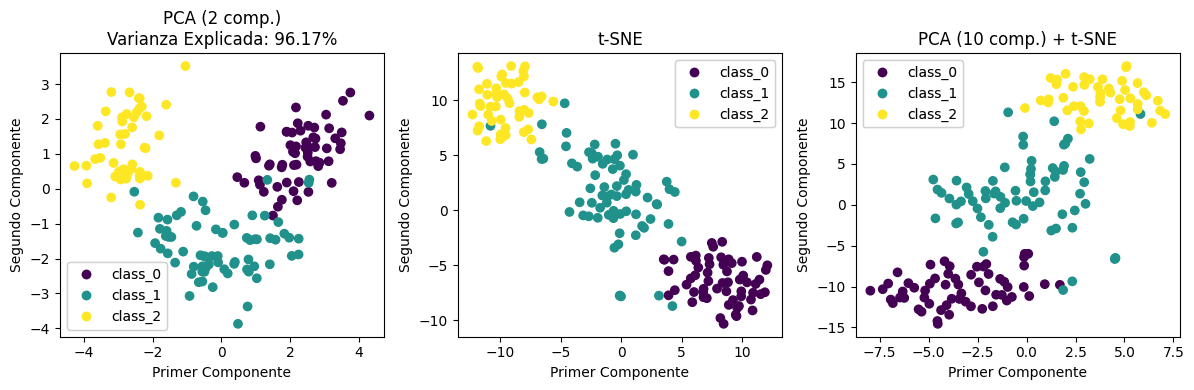

Dimensione inicial (variables): 13
Número de clases: 3
Número de componentes PCA para 95% de varianza: 10


In [15]:
# Cargar datos vino y analizar
wine = load_wine()
X_wine, y_wine, target_names = wine.data, wine.target, wine.target_names
n_components = compare_pca_tsne(X_wine, y_wine, target_names)

**Análisis de Resultados**

 - **PCA:**
  - Logra explicar aproximadamente el 55% de la varianza con 2 componentes
  - Muestra cierta separación entre las tres clases de vinos
  - Algunas clases se superponen en los bordes
  - Mantiene las relaciones globales entre tipos de vino

 - **t-SNE:**
  - Separa claramente los tres tipos de vino
  - Revela posibles subgrupos dentro de cada tipo
  - Mayor definición en la estructura de clusters
  - Mejor para identificar similitudes locales entre vinos

### **5.4. Resumen Comparación Técnicas**
- **Uso de PCA**:
 - Reducción dimensional preservando relaciones lineales
 - Preprocesamiento para otros algoritmos
 - Cuando la interpretabilidad es importante
 - Conjuntos de datos muy grandes
- **Uso de t-SNE**:
 - Visualización de clusters
 - Exploración de estructuras no lineales
 - Conjuntos de datos pequeños o medianos
 - Cuando el tiempo de computación no es crítico
- **Enfoque Combinado**:
 - PCA para reducción inicial de dimensionalidad
 - t-SNE para visualización final
 - Mejor balance entre tiempo de computación y calidad de visualización